# TODO: Zklend

In [30]:
from typing import Dict

import IPython.display
import pandas

from classes import State, Prices
#prices = classes.Prices()
import constants
import db

import matplotlib.pyplot as plt 


## Load and prepare events

In [5]:
# Establish the connection.
connection = db.establish_connection()

# Load all Zklend events.
zklend_events = pandas.read_sql(
    sql = 
    f"""
    SELECT
        *
    FROM
        starkscan_events
    WHERE
        from_address='{constants.Protocol.ZKLEND.value}'
    AND
        key_name IN ('Deposit', 'Withdrawal', 'CollateralEnabled', 'CollateralDisabled', 'Borrowing', 'Repayment', 'Liquidation', 'AccumulatorsSync')
    ORDER BY
        block_number ASC, id;
    """,
    con = connection,
)

# Close the connection.
connection.close()

/tmp/ipykernel_345302/2710962983.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  zklend_events = pandas.read_sql(


In [6]:
zklend_events.set_index('id', inplace = True)

# Process events

Events examples:
- [Deposit](https://starkscan.co/event/0x036185142bb51e2c1f5bfdb1e6cef81f8ea87fd4d777990014249bf5435fd31b_3)
- [AccumulatorsSync](https://starkscan.co/event/0x029628b89875a98c1c64ae206e7eb65669cb478a24449f3485f5e98aba6204dc_0)
- [CollateralEnabled](https://starkscan.co/event/0x036185142bb51e2c1f5bfdb1e6cef81f8ea87fd4d777990014249bf5435fd31b_6)
- [CollateralDisabled](https://starkscan.co/event/0x0049b445bed84e0118795dbd22d76610ccac2ad626f8f04a1fc7e38113c2afe7_0)
- [Withdrawal](https://starkscan.co/event/0x03472cf7511687a55bc7247f8765c4bbd2c18b70e09b2a10a77c61f567bfd2cb_4)
- [Borrowing](https://starkscan.co/event/0x076b1615750528635cf0b63ca80986b185acbd20fa37f0f2b5368a4f743931f8_3)
- [Repayment](https://starkscan.co/event/0x06fa3dd6e12c9a66aeacd2eefa5a2ff2915dd1bb4207596de29bd0e8cdeeae66_5)
- [Liquidation](https://starkscan.co/event/0x07b8ec709df1066d9334d56b426c45440ca1f1bb841285a5d7b33f9d1008f256_5)

In [7]:
# Iterate over ordered events to obtain the final state of each user.
state = State()
prices = Prices()
for _, event in zklend_events.iterrows():
    state.process_event(event = event)

In [13]:
# Get current prices of tokens.
#from classes import *
#prices = classes.Prices()

In [15]:
# Compute Health Factors 
from typing import Dict
import collections
import decimal
import classes

TOKEN_DECIMAL_FACTORS = {
    "ETH": decimal.Decimal('1e18'),
    "wBTC": decimal.Decimal('1e8'),
    "USDC": decimal.Decimal('1e6'),
    "DAI": decimal.Decimal('1e18'),
    "USDT": decimal.Decimal('1e6'),
}


# Source: https://zklend.gitbook.io/documentation/using-zklend/technical/asset-parameters.
COLLATERAL_FACTORS = {
    "ETH": decimal.Decimal('0.80'),
    "wBTC": decimal.Decimal('0.70'),
    "USDC": decimal.Decimal('0.80'),
    "DAI": decimal.Decimal('0.70'),
    "USDT": decimal.Decimal('0.70'),
}


# Source: https://zklend.gitbook.io/documentation/using-zklend/technical/asset-parameters.
LIQUIDATION_BONUSES = {
    "ETH": decimal.Decimal('0.10'),
    "wBTC": decimal.Decimal('0.15'),
    "USDC": decimal.Decimal('0.10'),
    "DAI": decimal.Decimal('0.10'),
    "USDT": decimal.Decimal('0.10'),
}


def compute_risk_adjusted_collateral_usd(
    user_state: classes.UserState,
    prices: Dict[str, decimal.Decimal],
) -> decimal.Decimal:
    return sum(
        token_state.collateral_enabled
        * token_state.deposit
        * COLLATERAL_FACTORS[token]
        * prices[token]
        # TODO: perform the conversion using TOKEN_DECIMAL_FACTORS sooner (in `UserTokenState`?)?
        / TOKEN_DECIMAL_FACTORS[token]
        for token, token_state
        in user_state.token_states.items()
    )


def compute_borrowings_usd(
    user_state: classes.UserState,
    prices: Dict[str, decimal.Decimal],
) -> decimal.Decimal:
    return sum(
        token_state.borrowings
        * prices[token]
        # TODO: perform the conversion using TOKEN_DECIMAL_FACTORS sooner (in `UserTokenState`?)?
        / TOKEN_DECIMAL_FACTORS[token]
        for token, token_state
        in user_state.token_states.items()
    )


def compute_health_factor(
    risk_adjusted_collateral_usd: decimal.Decimal,
    borrowings_usd: decimal.Decimal,
) -> decimal.Decimal:
    if borrowings_usd == decimal.Decimal('0'):
        # TODO: assumes collateral is positive
        return decimal.Decimal('Inf')

    health_factor = risk_adjusted_collateral_usd / borrowings_usd
    # TODO: enable?
#     if health_factor < decimal.Decimal('0.9'):
#         print(f'Suspiciously low health factor = {health_factor} of user = {user}, investigate.')
    # TODO: too many loans eligible for liquidation?
#     elif health_factor < decimal.Decimal('1'):
#         print(f'Health factor = {health_factor} of user = {user} eligible for liquidation.')
    return health_factor

In [16]:
for user, user_state in state.user_states.items():
    risk_adjusted_collateral_usd = compute_risk_adjusted_collateral_usd(
        user_state = user_state,
        prices = prices.prices,
    )
    borrowings_usd = compute_borrowings_usd(
        user_state = user_state,
        prices = prices.prices,
    )
    health_factor = compute_health_factor(
        risk_adjusted_collateral_usd = risk_adjusted_collateral_usd,
        borrowings_usd = borrowings_usd,
    )

In [17]:
# Compute Max Liquidation Borrowings 
def compute_borrowings_to_be_liquidated(
    risk_adjusted_collateral_usd: decimal.Decimal,
    borrowings_usd: decimal.Decimal,
    borrowings_token_price: decimal.Decimal,
    collateral_token_collateral_factor: decimal.Decimal,
    collateral_token_liquidation_bonus: decimal.Decimal,
) -> decimal.Decimal:
    # TODO: commit the derivation of the formula in a document?
    numerator = borrowings_usd - risk_adjusted_collateral_usd
    denominator = borrowings_token_price * (
        1 - collateral_token_collateral_factor * (
            1 + collateral_token_liquidation_bonus
        )
    )
    return numerator / denominator


def compute_max_liquidated_amount(
    state: classes.State,
    prices: Dict[str, decimal.Decimal],
    borrowings_token: str,
) -> decimal.Decimal:
    liquidated_borrowings_amount = decimal.Decimal('0')
    for user, user_state in state.user_states.items():
        # TODO: do this?
        # Filter out users who borrowed the token of interest.
        borrowings_tokens = {
            token_state.token
            for token_state in user_state.token_states.values()
            if token_state.borrowings > decimal.Decimal('0')
        }
        if not borrowings_token in borrowings_tokens:
            continue

        # Filter out users with health below 1.
        risk_adjusted_collateral_usd = compute_risk_adjusted_collateral_usd(
            user_state = user_state,
            prices = prices,
        )
        borrowings_usd = compute_borrowings_usd(
            user_state = user_state,
            prices = prices,
        )
        health_factor = compute_health_factor(
            risk_adjusted_collateral_usd = risk_adjusted_collateral_usd,
            borrowings_usd = borrowings_usd,
        )
        if health_factor >= decimal.Decimal('1'):
            continue

        # TODO: find out how much of the borrowings_token will be liquidated
        collateral_tokens = {
            token_state.token
            for token_state in user_state.token_states.values()
            if token_state.deposit * token_state.collateral_enabled > decimal.Decimal('0')
        }
        # TODO: choose the most optimal collateral_token to be liquidated .. or is the liquidator indifferent?
        collateral_token = list(collateral_tokens)[0]
        liquidated_borrowings_amount += compute_borrowings_to_be_liquidated(
            risk_adjusted_collateral_usd = risk_adjusted_collateral_usd,
            borrowings_usd = borrowings_usd,
            borrowings_token_price = prices[borrowings_token],
            collateral_token_collateral_factor = COLLATERAL_FACTORS[collateral_token],
            collateral_token_liquidation_bonus = LIQUIDATION_BONUSES[collateral_token],
        )
    return liquidated_borrowings_amount



In [19]:
import copy


COLLATERAL_TOKEN = 'wBTC'
BORROWINGS_TOKEN = 'USDC'
COLLATERAL_TOKEN_PRICE_MULTIPLIER = decimal.Decimal('0.99')


def simulate_liquidations_under_price_change(
    prices: classes.Prices,
    collateral_token: str,
    collateral_token_price_multiplier: decimal.Decimal,
    state: classes.State,
    borrowings_token: str,
) -> decimal.Decimal:
    changed_prices = copy.deepcopy(prices.prices)
    changed_prices[collateral_token] *= collateral_token_price_multiplier
    return compute_max_liquidated_amount(state = state, prices = changed_prices, borrowings_token = borrowings_token)


    simulate_liquidations_under_price_change(
        prices = prices,
        collateral_token = COLLATERAL_TOKEN,
        collateral_token_price_multiplier = COLLATERAL_TOKEN_PRICE_MULTIPLIER,
        state = state,
        borrowings_token = BORROWINGS_TOKEN,
    )

(array([10., 10., 10., 10., 10., 10., 11.,  9., 10., 11.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <BarContainer object of 10 artists>)

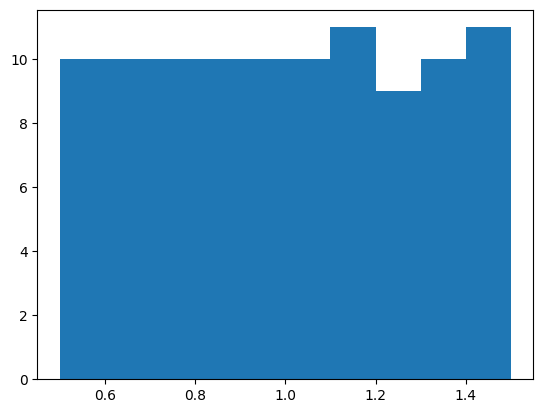

In [29]:
import numpy


COLLATERAL_TOKEN = 'ETH'
BORROWINGS_TOKEN = 'USDC'


def decimal_range(start: decimal.Decimal, stop: decimal.Decimal, step: decimal.Decimal):
    while start < stop:
        yield start
        start += step


data = pandas.DataFrame(
    {
        'collateral_token_price_multiplier': [
            x
            for x
            in decimal_range(
                start = decimal.Decimal('0.5'),
                stop = decimal.Decimal('1.51'),
                step = decimal.Decimal('0.01'),
            )
        ]
    },
)
data['collateral_token_price_multiplier'] = data['collateral_token_price_multiplier'].map(decimal.Decimal)
data['max_borrowings_to_be_liquidated'] = \
    data['collateral_token_price_multiplier'].apply(
        lambda x: simulate_liquidations_under_price_change(
            prices = prices,
            collateral_token = COLLATERAL_TOKEN,
            collateral_token_price_multiplier = x,
            state = state,
            borrowings_token = BORROWINGS_TOKEN,
        )
    )
data


In [26]:
#import plotly.express

#figure = plotly.express.bar(x = 'collateral_token_price_multiplier', y = 'max_borrowings_to_be_liquidated')
#figure.show()

# TODO: Debugging negative deposits below

In [23]:
# TODO: negative deposits?
print("Action   Token   Raw value   Raw $   Readable $")
for attr in ['deposit', 'borrowings']:
    for token in ['ETH', 'wBTC', 'USDC', 'DAI', 'USDT']:
        values = [getattr(user_state.token_states[token], attr) for user, user_state in state.user_states.items()]
        print(attr, token, pandas.Series(values).min(), f"${prices.to_dollars(pandas.Series(values).min(), token)}", prices.to_dollars_pretty(pandas.Series(values).min(), token))

Action   Token   Raw value   Raw $   Readable $
deposit ETH -5664598294961056416.478305722 $-10582.31930473149805963616053 $-10582.31930
deposit wBTC -152606.7275111500126986956235 $-46.36192381788737385786373042 $-46.36192
deposit USDC -5342655434.340521419018333909 $-5337.157841898585307647581885 $-5337.15784
deposit DAI -189817314514137233439.1568486 $-189.7123455392109106720459624 $-189.71235
deposit USDT -299418009.8303883409414079880 $-299.3608209905107211269602429 $-299.36082
borrowings ETH -778520881882813324 $-1454.393785489377782036661729 $-1454.39379
borrowings wBTC -106514 $-32.35895320 $-32.35895
borrowings USDC -5030122374 $-5024.946378077154268487662492 $-5024.94638
borrowings DAI -490397886374677978257 $-490.1266963435127687351204854 $-490.12670
borrowings USDT -2272131644 $-2271.697666855995881305883444 $-2271.69767


In [ ]:
# TODO: show negative deposits
[
    (user, user_state.token_states['USDT'].deposit)
    for user, user_state
    in state.user_states.items()
    if user_state.token_states['USDT'].deposit < 0
]

[('0x4a587e33647247ed71d178b25155a27463765f7c113f05904126692d348cab1',
  Decimal('-4997676.927172805096183238170'))]

In [ ]:
# TODO: Get token prices here: https://www.coingecko.com/en/api/documentation